This jupyter notebook presents the most straighforward GAN code that can be used for enhancing image resolution. Because enhancing image resolution means increasing the pixels in the image to improve quality, it requires a largr and complex model. Thus this GAN model needs high hardware requirements to be trained.

# Import Required Modules

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Activation, PReLU
from tensorflow.keras.layers import Flatten, Concatenate, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
# Import Path for file system operations
from pathlib import Path

from google.colab import drive

# Download Dataset

In [5]:
# Mount droive to load div2K data that is saved there
# Dataset can be downloaded from "https://data.vision.ee.ethz.ch/cvl/DIV2K/"
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unzip The Dataset

In [7]:
# Unzip train and test images
!unzip -q "/content/drive/MyDrive/DIV2K/DIV2K_train_HR.zip" -d "/content/"
!unzip -q "/content/drive/MyDrive/DIV2K/DIV2K_valid_HR.zip" -d "/content/"
!unzip -q "/content/drive/MyDrive/DIV2K/DIV2K_train_LR_difficult.zip" -d "/content/"
!unzip -q "/content/drive/MyDrive/DIV2K/DIV2K_valid_LR_difficult.zip" -d "/content/"

# Load Image Data

In [14]:
width_LR, height_LR = 255, 255
# load source images for training
train_data_source = []
image_id = []
for image_file in glob('/content/DIV2K_train_LR_difficult/*.png'):
  image_id.append(Path(image_file).name.split(".")[0])
  single_image = load_img(image_file, target_size=(width_LR, height_LR))
  img = img_to_array(single_image)
  # normalize pixel values to the range [0, 1]
  img = img / 255.0
  train_data_source.append(img)

sorted_id = sorted(image_id)

LR = dict(zip(image_id, train_data_source))
LR_train = {i: LR[i] for i in sorted_id}

LR_source_train = []
for value in LR_train.values():
  LR_source_train.append(value)

In [16]:
width_HR, height_HR = 2040, 2040
# load source images for training
train_data_target = []
image_id = []
for image_file in glob('/content/DIV2K_train_HR/*.png'):
  image_id.append(Path(image_file).name.split(".")[0])
  single_image = load_img(image_file, target_size=(width_HR, height_HR))
  img = img_to_array(single_image)
  # normalize pixel values to the range [0, 1]
  img = img / 255.0
  train_data_target.append(img)

sorted_id = sorted(image_id)

HR = dict(zip(image_id, train_data_target))
HR_train = {i: HR[i] for i in sorted_id}

HR_target_train = []
for value in HR_train.values():
  HR_target_train.append(value)

In [8]:
# load source images for validation
valid_data_source = []
image_id = []
for image_file in glob('/content/DIV2K_valid_LR_difficult/*.png'):
  image_id.append(Path(image_file).name.split(".")[0])
  single_image = load_img(image_file, target_size=(width_LR, height_LR))
  img = img_to_array(single_image)
  # normalize pixel values to the range [0, 1]
  img = img / 255.0
  valid_data_source.append(img)

sorted_id = sorted(image_id)

LR = dict(zip(image_id, valid_data_source))
LR_valid = {i: LR[i] for i in sorted_id}

LR_source_valid = []
for value in LR_valid.values():
  LR_source_valid.append(value)

In [ ]:
# load target images for validation
valid_data_target = []
image_id = []
for image_file in glob('/content/DIV2K_valid_HR/*.png'):
  image_id.append(Path(image_file).name.split(".")[0])
  single_image = load_img(image_file, target_size=(width_HR, height_HR))
  img = img_to_array(single_image)
  # normalize pixel values to the range [0, 1]
  img = img / 255.0
  valid_data_target.append(img)

sorted_id = sorted(image_id)

HR = dict(zip(image_id, valid_data_target))
HR_valid = {i: HR[i] for i in sorted_id}

HR_target_valid = []
for value in HR_valid.values():
  HR_target_valid.append(value)

# Plot Sample of source and target Images

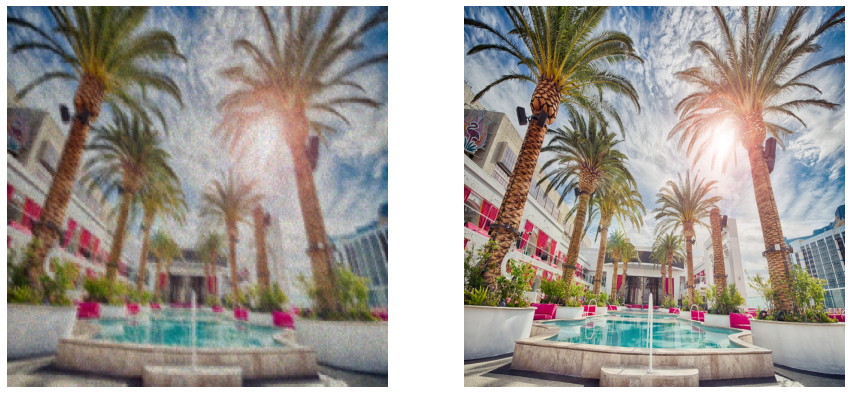

In [19]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].imshow(LR_source_train[2])
axs[1].imshow(HR_target_train[2])
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.show()

# Build The Generator

In [22]:
def build_generator():
  # Define input low resolution image shape
  input_image = Input(shape = (width_LR, height_LR, 3))

  # Add convolution layer to extract features from the low resolution image
  features = Conv2D(64, 9, padding = "same")(input_image)
  features = BatchNormalization()(features)
  features = PReLU(shared_axes=[1,2])(features)
  
  model = features
  # Using 16 Residual Blocks
  for index in range(16):
    res_model = features
    features = Conv2D(64, 3, padding = "same")(features)
    features = BatchNormalization()(features)
    features = PReLU(shared_axes=[1,2])(features)
    features = Conv2D(64, 3, padding = "same")(features)
    features = BatchNormalization()(features)
    features = add([res_model, features])
    
  features = Conv2D(64, 3, padding = "same")(features)
  features = BatchNormalization()(features)
  features = add([model, features])
  
  # Upsample to reach high resolution image dimensions 
  features = Conv2D(256, 3, padding = "same")(features)
  features = UpSampling2D(size = 2)(features)
  features = LeakyReLU(alpha = 0.2)(features)
  features = Conv2D(256, 3, padding = "same")(features)
  features = UpSampling2D(size = 2)(features)
  features = LeakyReLU(alpha = 0.2)(features)
  features = Conv2D(256, 3, padding = "same")(features)
  features = UpSampling2D(size = 2)(features)
  features = LeakyReLU(alpha = 0.2)(features)
    
  features = Conv2D(3, 9, padding = "same")(features)
  output_image = Activation('sigmoid')(features)
  
  generator_model = Model(inputs = input_image, outputs = output_image)
  return generator_model

In [23]:
generator = build_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 255, 255, 64  15616       ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 255, 255, 64  256        ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

# Build The Discriminator

In [24]:
def build_discriminator():
    input_source_image = Input(shape=(width_HR, height_HR, 3))
    input_target_image = Input(shape=(width_HR, height_HR, 3))
    
    merged = Concatenate()([input_source_image, input_target_image])

    # Downsample
    x = Conv2D(16, kernel_size=4, strides=2, padding='same')(merged)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(32, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Flatten layer
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    disc_model = Model([input_source_image, input_target_image], outputs= output)

    #compile model
    discriminator_optimizer = Adam(lr=0.0002, beta_1=0.5)
    disc_model.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, loss_weights=[0.5])
    
    return disc_model

In [25]:
discriminator = build_discriminator()
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2040, 2040,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_4 (InputLayer)           [(None, 2040, 2040,  0           []                               
                                 3)]                                                              
                                                                                                  
 concatenate (Concatenate)      (None, 2040, 2040,   0           ['input_3[0][0]',                
                                6)                                'input_4[0][0]']          

# Build Adversarial Network

In [26]:
def build_gan(generator, discriminator):
  discriminator.trainable = False
  input_source = Input(shape=(width_LR, height_LR, 3))
  input_target = Input(shape=(width_HR, height_HR, 3))
  target_image = generator(input_source)
  validity =  discriminator([input_target, target_image])
  gan = Model(inputs=[input_source, input_target], outputs=[validity, target_image])

  gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  gan.compile(loss=["binary_crossentropy", "mae"], optimizer=gan_optimizer, loss_weights=[1,100])
  return gan

In [27]:
gan_model = build_gan(generator, discriminator)
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 255, 255, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 2040, 2040,  0           []                               
                                 3)]                                                              
                                                                                                  
 model_1 (Functional)           (None, 2040, 2040,   2634115     ['input_5[0][0]']                
                                3)                                                          

# Print Output Images

In [ ]:
def print_generated_images(generator_model, test_source_image, test_target_image):
  generated_image = generator_model(test_source_image, training=True)
  
  title = ['Low Resolution Input Image', 'High Resolution Traget Image', 'High Resolution Generated Image']

  # Create a figure with three subplots
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
  fig.set_figheight(15)
  fig.set_figwidth(15)
  
  for i in range(3):
    # Plot the images on their respective subplots
    ax1.imshow(test_source_image[i])
    ax2.imshow(test_target_image[i])
    ax3.imshow(generated_image[i])

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
  
    # Add the titles to each subplot
    ax1.set_title(title[0])
    ax2.set_title(title[1])
    ax3.set_title(title[2])
    # Show the plot
    plt.show()

# Custom Training Loop

In [ ]:
import os
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
gan_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
checkpoint_dir = '/content/drive/MyDrive/Enhancement'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(discriminator_opt=discriminator_optimizer,
                                 gan_opt=gan_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 GAN = gan_model
                                 )

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def training(generator, discriminator, gan, epochs, batch_size):
    # to set the batch size
    steps = len(LR_source_train) // batch_size

    # enumerate over epochs
    for e in range(epochs):
        # enumerate batches over the training data
        for b in range(steps):
            # create source batch images
            random_batch_index = np.random.randint(0, len(LR_source_train), size = batch_size)
            source_images = [LR_source_train[i] for i in random_batch_index]
            # source_images = source_images.reshape((batch_size, width, height, 3))
            # reshaped_source_images = tf.reshape(source_images, (batch_size, width_LR, height_LR, 3))
            reshaped_source_images = np.array(source_images)

            # create target batch images
            target_images = [HR_target_train[i] for i in random_batch_index]
            # target_images = target_images.reshape((batch_size, width, height, 3))
            # reshaped_target_images = tf.reshape(target_images, (batch_size, width_HR, height_HR, 3))
            reshaped_target_images = np.array(target_images)

            # create fake images by the generator
            fake_target_images = generator.predict(reshaped_source_images)


            # generate fake labels generated images as zeros
            fake_labels = np.zeros([batch_size, 1])
            # generate real labels for real data as ones
            real_labels = np.ones([batch_size, 1])*0.9

            # Calculate the loss of real data points
            discriminator_loss_real = discriminator.train_on_batch([reshaped_source_images, reshaped_target_images], real_labels)
            # Calculate the loss of generated data points
            discriminator_loss_fake = discriminator.train_on_batch([reshaped_source_images, fake_target_images], fake_labels)
            # Compute total discriminator loss
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            # calculate the generator loss
            indices = np.random.randint(0, len(LR_source_train), size=batch_size)
            source_images = [LR_source_train[i] for i in indices]
            reshaped_source_images = np.array(source_images)
            target_images = [HR_target_train[i] for i in indices]
            # reshaped_target_images = np.reshape(target_images, (batch_size, width_HR, height_HR, 3))
            reshaped_target_images = np.array(target_images)
            y_gan = np.ones((batch_size, 1))
            generator_loss, _, _ = gan.train_on_batch([reshaped_source_images, reshaped_target_images], [y_gan, reshaped_target_images])

            # if the remainder of dividing current epoch number by 10 equal to 0 print the following image
            if (e) % 10 == 0:
                print('Epoch: ', e, ' Generator Loss: ', generator_loss, ' Discriminator Loss: ', discriminator_loss)

        if e% 1 == 0 :
          ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)
          ckpt_manager.save(checkpoint_number=e)

        # if this is the last ephoch print the generated images
        if (e) % 10 == 0 or (e) == epochs-1:
            test_indices = np.random.randint(0, len(LR_source_valid), size = batch_size//2)
            test_source = [LR_source_valid[i] for i in test_indices]
            reshaped_source_test = np.array(test_source)
            # reshaped_source_test = tf.reshape(test_source, (batch_size//2, width_LR, height_LR, 3))
            test_target = [HR_target_valid[i] for i in test_indices]
            reshaped_target_test = np.array(test_target)
            # reshaped_target_test = tf.reshape(test_target, (batch_size//2, width_HR, height_HR, 3))
            print_generated_images(generator, reshaped_source_test, reshaped_target_test)

# training(generator, discriminator, gan_model, 10000, 128) 

# Call Training Loop

In [ ]:
training(generator, discriminator, gan_model, 10000, 128) 